<a href="https://colab.research.google.com/github/EilieYoun/Narnia-Edu/blob/main/Lecture/240822_kaist/01_Diffusion_%ED%95%B4%EC%84%A4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2024 KAIST 생성AI 실습 :  Diffusion

* 날짜:
* 이름:




## **(0) Environment Setup**
---

In [ ]:
!pip install --upgrade diffusers[torch]

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
!unzip carhood_npy.zip -d carhood

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from mpl_toolkits.axes_grid1 import make_axes_locatable



def draw_img_from_cond(skin, geo, cmap='gray'):
    plt.figure(figsize=(3,3))
    path = f'carhood/skin_{skin}_geometry_{geo}.npy'
    img = np.load(path)
    plt.imshow(img, cmap=cmap)
    plt.colorbar()
    plt.show()
    return img


def draw_dist(inputs, samples=100):
    if len(inputs) > samples:
        inputs = random.sample(list(inputs), samples)

    pixel_values = []
    for item in inputs:
        if isinstance(item, Image.Image):
            pixel_values.extend(list(item.getdata()))
        elif isinstance(item, np.ndarray):
            pixel_values.extend(item.flatten())
        elif torch.is_tensor(item):
            if len(item.shape) == 4 and item.shape[1] == 1:  # 이미지가 (batch_size, 1, height, width) 꼴일 때
                item = item.squeeze(1)
            elif len(item.shape) == 3:  # 이미지가 (batch_size, height, width) 꼴일 때
                item = item.unsqueeze(1)
            else:
                raise ValueError("Unsupported image shape. Supported shapes: (batch_size, height, width) or (batch_size, 1, height, width).")
            item = item.detach().cpu().numpy()
            pixel_values.extend(item.flatten())
        else:
            raise ValueError("Unsupported image type. Supported types: PIL Image, numpy array, torch tensor.")

    plt.figure(figsize=(5,3))
    plt.hist(pixel_values, bins=20, color='blue', alpha=0.7)
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.title('Image Pixel Value Distribution')
    plt.show()



def show_img(images_list,
             r=1,
             cmap='gray',
             img_size=(5, 5),
             axis="off",
             colorbar=False,
             colorbar_range=None,
             save_path=None):
    if r < 1:
        r = 1

    total_images = len(images_list)
    if total_images == 0:
        print("No images to display.")
        return

    cols = (total_images + r - 1) // r
    fig, axs = plt.subplots(r, cols, figsize=(cols * img_size[0], r * img_size[1]))

    if r == 1:
        axs = axs.reshape(1, -1)

    for idx, item in enumerate(images_list):
        ax = axs[0, idx] if r == 1 else axs[idx // cols, idx % cols]
        im = None
        if isinstance(item, Image.Image):
            if item.mode in ['L', '1']:  # Grayscale images
                im = ax.imshow(item, cmap=cmap)
            else:  # Color images
                im = ax.imshow(item)
        elif isinstance(item, np.ndarray):
            if item.ndim == 2:  # 2D array, grayscale image
                im = ax.imshow(item, cmap=cmap, vmin=colorbar_range[0] if colorbar_range else None, vmax=colorbar_range[1] if colorbar_range else None)
            elif item.ndim == 3:  # 3D array, color image
                im = ax.imshow(item, cmap=cmap if item.shape[-1] == 1 else None, vmin=colorbar_range[0] if colorbar_range else None, vmax=colorbar_range[1] if colorbar_range else None)
            elif item.ndim == 4 and item.shape[0] == 1:  # 4D array with batch dimension of 1
                im = ax.imshow(item[0], cmap=cmap if item.shape[1] == 1 else None, vmin=colorbar_range[0] if colorbar_range else None, vmax=colorbar_range[1] if colorbar_range else None)
            else:
                raise ValueError(f"Unsupported numpy array shape: {item.shape}.")
        elif torch.is_tensor(item):
            item = item.detach().cpu().numpy()
            if item.ndim == 2:  # 2D tensor, grayscale image
                im = ax.imshow(item, cmap=cmap, vmin=colorbar_range[0] if colorbar_range else None, vmax=colorbar_range[1] if colorbar_range else None)
            elif item.ndim == 3:  # 3D tensor, color image
                im = ax.imshow(item.transpose(1, 2, 0), cmap=cmap if item.shape[0] == 1 else None, vmin=colorbar_range[0] if colorbar_range else None, vmax=colorbar_range[1] if colorbar_range else None)
            elif item.ndim == 4 and item.shape[0] == 1:  # 4D tensor with batch dimension of 1
                im = ax.imshow(item[0].transpose(1, 2, 0), cmap=cmap if item.shape[1] == 1 else None, vmin=colorbar_range[0] if colorbar_range else None, vmax=colorbar_range[1] if colorbar_range else None)
            else:
                raise ValueError(f"Unsupported torch tensor shape: {item.shape}.")
        else:
            raise ValueError("Unsupported image type. Supported types: PIL Image, numpy array, torch tensor.")

        if colorbar and im is not None:
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            fig.colorbar(im, cax=cax)

        ax.axis(axis)

    plt.tight_layout()
    # 이미지 저장
    if save_path is not None:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches='tight')
        plt.close()
    else:
        plt.show()

## **(1) Dataset**

### **| EDA**

**데이터 소개**


`CarHoods10k` 데이터셋은 10,000개 이상의 자동차 후드 프레임 3D 메쉬 형상으로 구성되었으며, 자동화된 CAD 워크플로우를 통해 생성되었습니다. 이 데이터셋은 현실성과 제조 가능성에 대해 전문가의 검증을 거쳤습니다. 기초 형상 및 FEA(유한 요소 해석) 성능 지표가 포함되어 있으며, 자동차 공학 및 기타 분야에서 최적화 및 머신러닝 방법을 평가하고 개발하는 데 유용한 데이터를 제공합니다​ (DataDryad)​.

`CarHoods10k` 데이터셋은 `Creative Commons Zero (CC0)` 라이센스로 제공됩니다. 이 라이센스는 사용자가 저작권을 포기한 것으로, 누구나 자유롭게 데이터를 복제, 수정, 배포, 심지어 상업적 목적으로도 사용할 수 있습니다. 사용자는 출처를 명시할 필요가 없으며, 데이터 사용에 대한 법적 제한이 없습니다

이번 시간에 다룰 데이터는 `CarHood10k` 메쉬 데이터셋을 256x256 해상도의 depthmap으로 가공한 것입니다. 전체 데이터 중 무작위로 선택한 1,000개의 `depthmap npy` 파일을 사용하여 실습을 진행할 예정입니다.

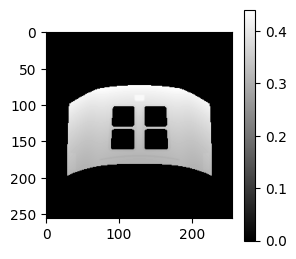

(256, 256)


In [ ]:
img = draw_img_from_cond(41, 29)
print(img.shape)

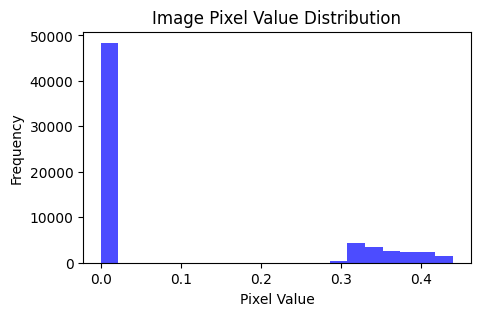

In [ ]:
draw_dist([img])

### **| DataLoader**

In [ ]:
import torch
import numpy as np
import glob
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms


class PP(Dataset):

    def __init__(self,
                 paths=[],
                 resize=None,
                 batch_size: int = 4,
                 shuffle: bool = True,
                 dtype = torch.float16,
                ):

        # init
        self.paths = paths

        self.resize = resize
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.dtype = dtype

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):

        path = self.paths[idx]
        x = np.load(path)
        x = x * 4. - 1.
        x = torch.tensor(x, dtype=self.dtype).unsqueeze(0)
        if self.resize is not None:
            x = transforms.Resize(self.resize)(x)

        return x

    def get_loader(self):
        return DataLoader(self, batch_size=self.batch_size, shuffle=self.shuffle)

    def get_batch(self, idx=0):
        ds = self.get_loader()
        for i, batch in enumerate(ds):
            if i == idx:
                break
        return batch

torch.Size([4, 1, 128, 128])


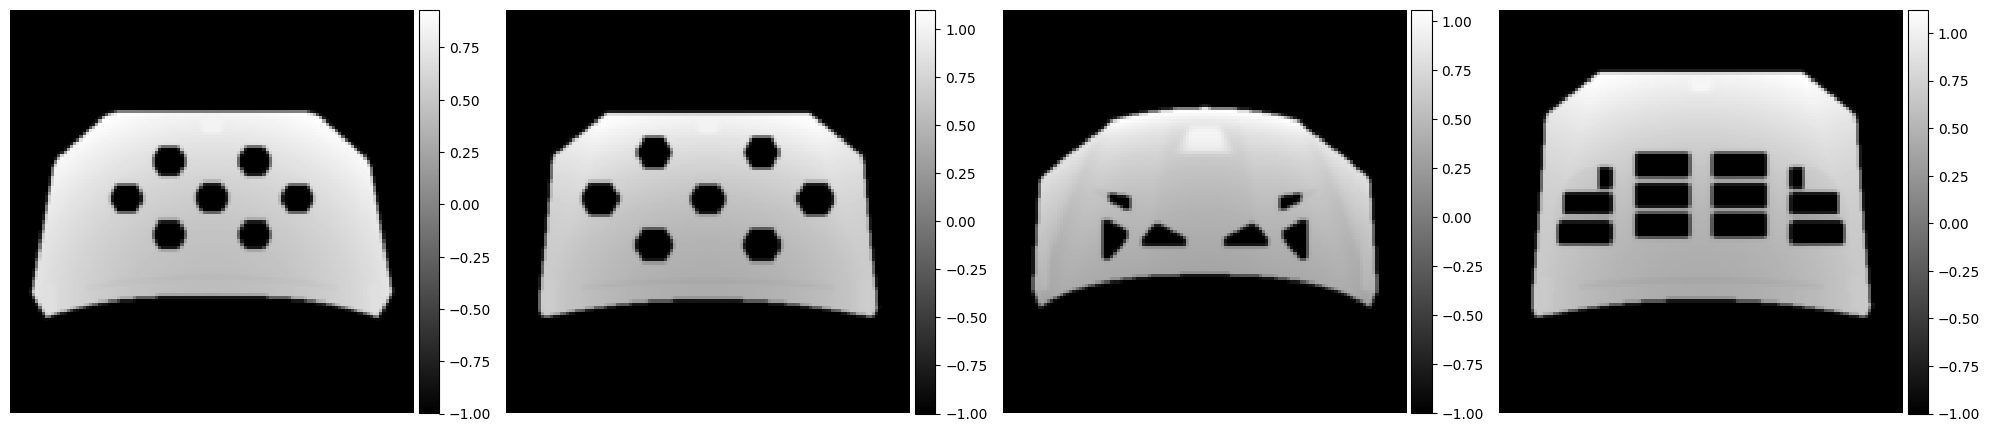

In [ ]:
import glob
paths= glob.glob('carhood/*npy')
pp = PP(paths, resize=128)
images = pp.get_batch(0)
print(images.shape)
show_img(images, colorbar=True)

## **(2) Modules**



![](https://github.com/EilieYoun/box/blob/main/images/240214_ddpm.png?raw=true)


**Diffusion**은 이미지를 점진적으로 정제하는 과정을 통해 노이즈를 제거하고, 원래 이미지를 복원하는 생성 모델입니다. 이번 시간에서는 **DDIM** (Denoising Diffusion Implicit Models)을 사용하여 노이즈를 추가하고 제거하는 과정을 수행합니다.

이번 실습에서는 **Hugging Face**에서 제공하는 `diffusers` 라이브러리를 사용하여 **Diffusion** 모델을 구축합니다. 이 라이브러리는 다양한 **Diffusion** 모델을 쉽게 구현하고 실험할 수 있는 도구를 제공합니다. `diffusers` 라이브러리는 모듈화된 구조를 가지고 있어, 다양한 모델 구성 요소를 쉽게 설정하고 사용할 수 있습니다. 자세한 내용은 https://github.com/huggingface 에서 확인할 수 있습니다.


### **| UNet**

첫 번째 모듈은 UNet입니다. UNet은 이미지 분할 및 재구성 작업에 널리 사용되는 네트워크 구조로, 이번 실습에서는 노이즈를 예측하는 데 사용됩니다. 모듈에 관한 자세한 내용은 [Hugging Face UNET 페이지](https://github.com/huggingface/diffusers/blob/main/src/diffusers/models/unet/unet_2d.py)에서 확인할 수 있습니다.

- `UNet2DModel`을 사용하여 **UNet** 모델을 정의합니다.
- 입력이미지와 채널 수를 적절하게 정의해 줍니다.
- `layers_per_block`과 `block_out_channels`를 기존보다 작게 설정해 가벼운 모델을 만듭니다.

In [ ]:
from diffusers import UNet2DModel

unet = UNet2DModel(
    sample_size = 128,
    in_channels = 1,
    out_channels = 1,
    layers_per_block = 1,
    block_out_channels = [64, 128, 256, 512],
)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

- `noisy_images`와 `timestep`을 입력으로 받아 예측된 노이즈를 출력합니다.


torch.Size([4, 1, 128, 128])


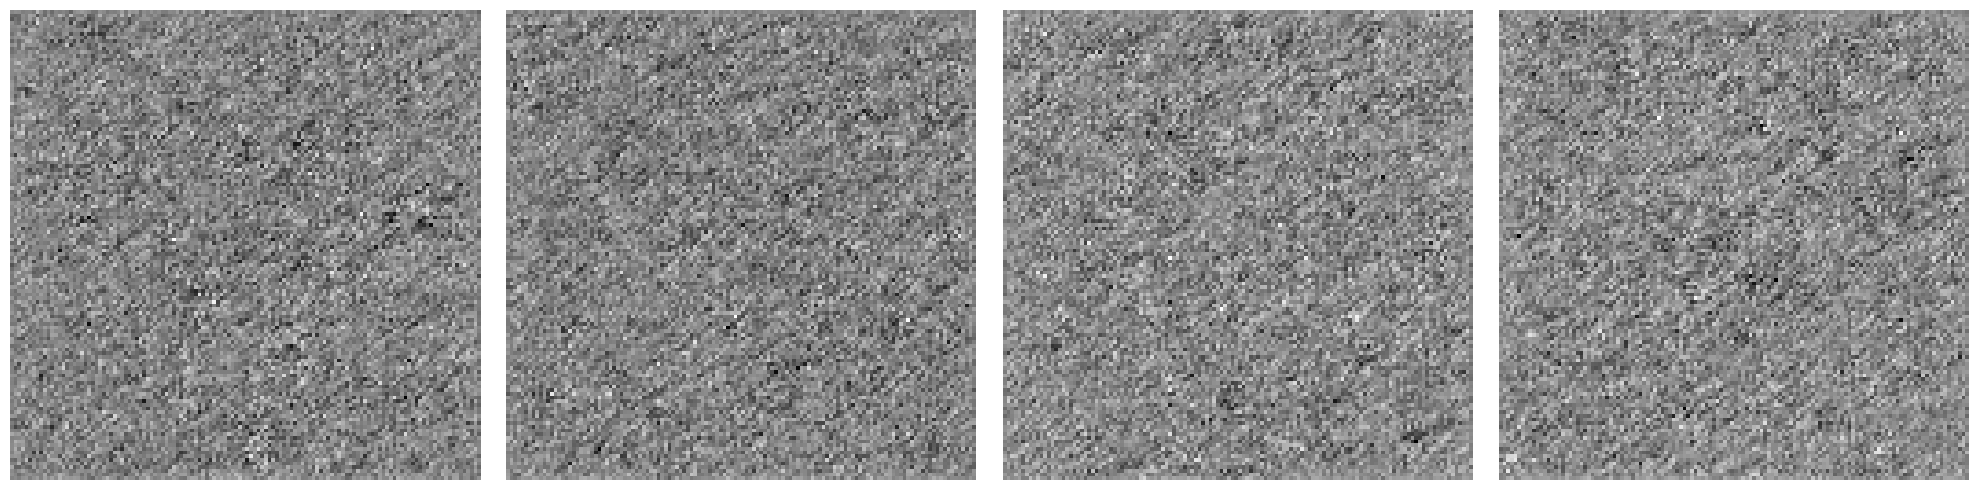

In [ ]:
noisy_images = torch.randn((4, 1, 128, 128))
timestep = torch.tensor([10])
with torch.no_grad():
    pred_noises = unet(noisy_images, timestep).sample
print(pred_noises.shape)
show_img(pred_noises)

### **| Noise scheduler**

두 번째 모듈은 **DDIM Noise Scheduler**입니다. **DDIM**은 Denoising Diffusion Implicit Models의 약자로, 이미지 생성 과정에서 점진적으로 노이즈를 제거하는 역할을 합니다. 이번 실습에서는 노이즈 추가 및 제거를 통해 이미지 재구성을 수행합니다. 모듈에 관한 자세한 내용은 [Hugging Face DDIM 페이지](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_ddim.py)에서 확인할 수 있습니다.

- `DDIMScheduler`를 사용하여 **Noise Scheduler**를 설정합니다. 이 모듈은 각 타임스텝에서 노이즈를 추가하거나 제거하는 역할을 합니다.
- `num_train_timesteps`를 통해 전체 학습 타임스텝 수를 정의합니다.


In [ ]:
from diffusers import UNet2DModel, DDIMScheduler

noise_scheduler = DDIMScheduler(num_train_timesteps=1000)

- `set_timesteps()` 를 통해 사용할 타임스텝 수를 설정하고, 설정된 타임스텝을 출력합니다.

In [ ]:
noise_scheduler.set_timesteps(5) # noise scheduler timesteps 설정
print('timesteps : ', len(noise_scheduler.timesteps), noise_scheduler.timesteps) # timesteps 확인

timesteps :  5 tensor([800, 600, 400, 200,   0])


**노이즈 추가**

- `noise_scheduler.timesteps`를 반복하면서 각 타임스텝마다 노이즈를 추가합니다. 이는 원래 이미지에 점진적으로 노이즈를 더해가며 모델을 훈련시키기 위한 과정입니다.
- `torch.randn`을 사용하여 랜덤 노이즈를 생성합니다.
- `noise_scheduler.add_noise` 메서드를 통해 노이즈 이미지로 변환합니다.
- 노이즈 이미지를 시각화하여 확인합니다.

tensor(800)


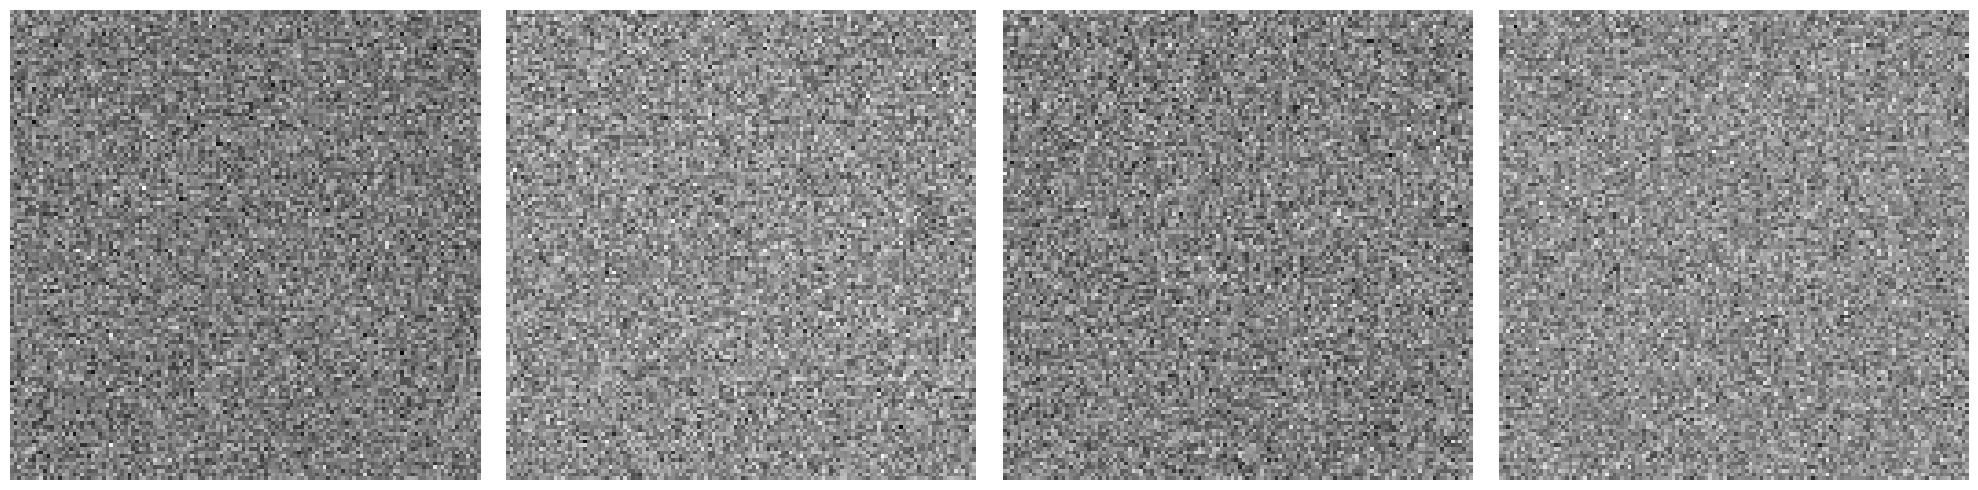

tensor(600)


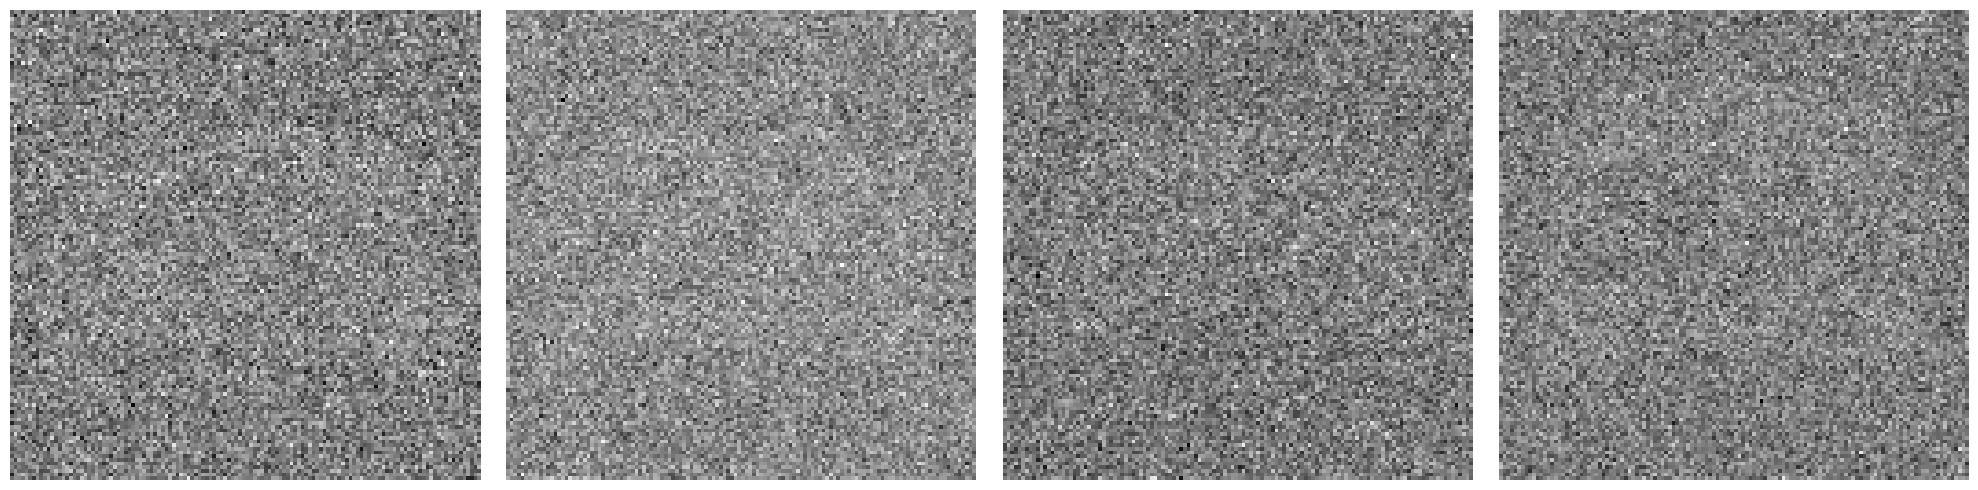

tensor(400)


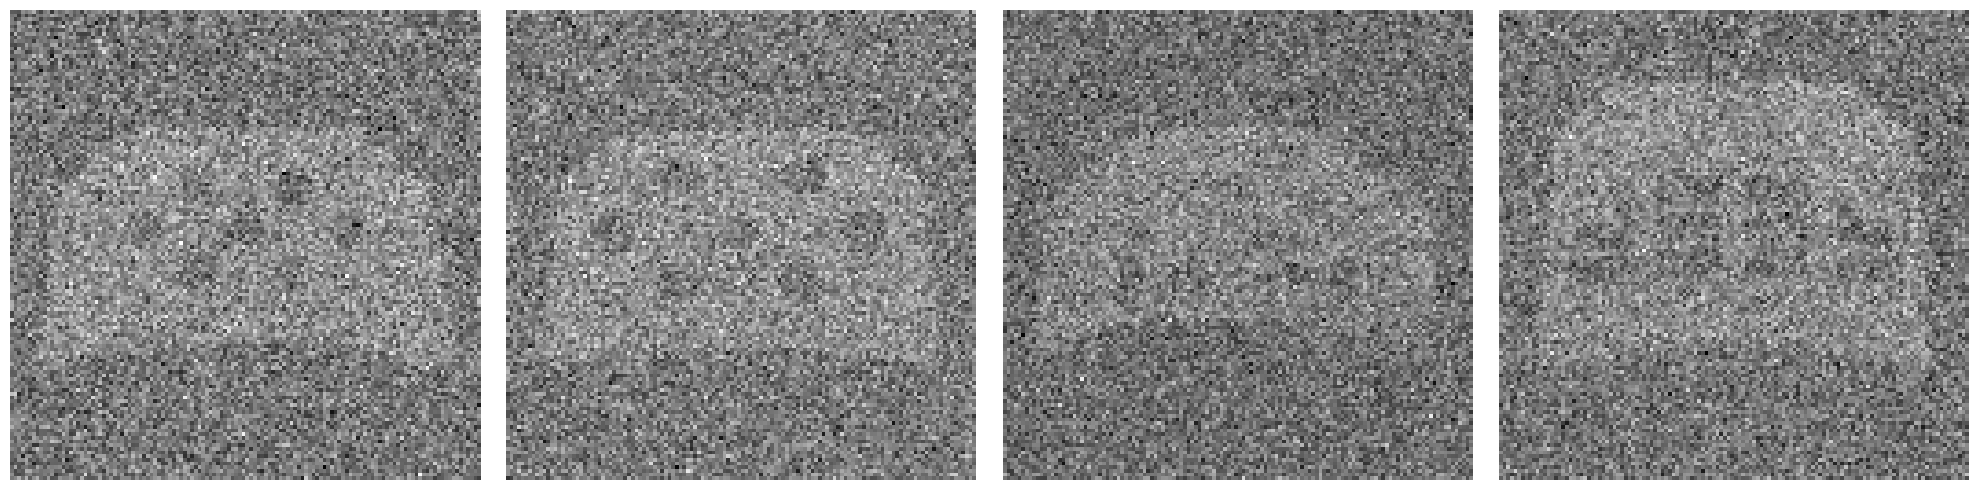

tensor(200)


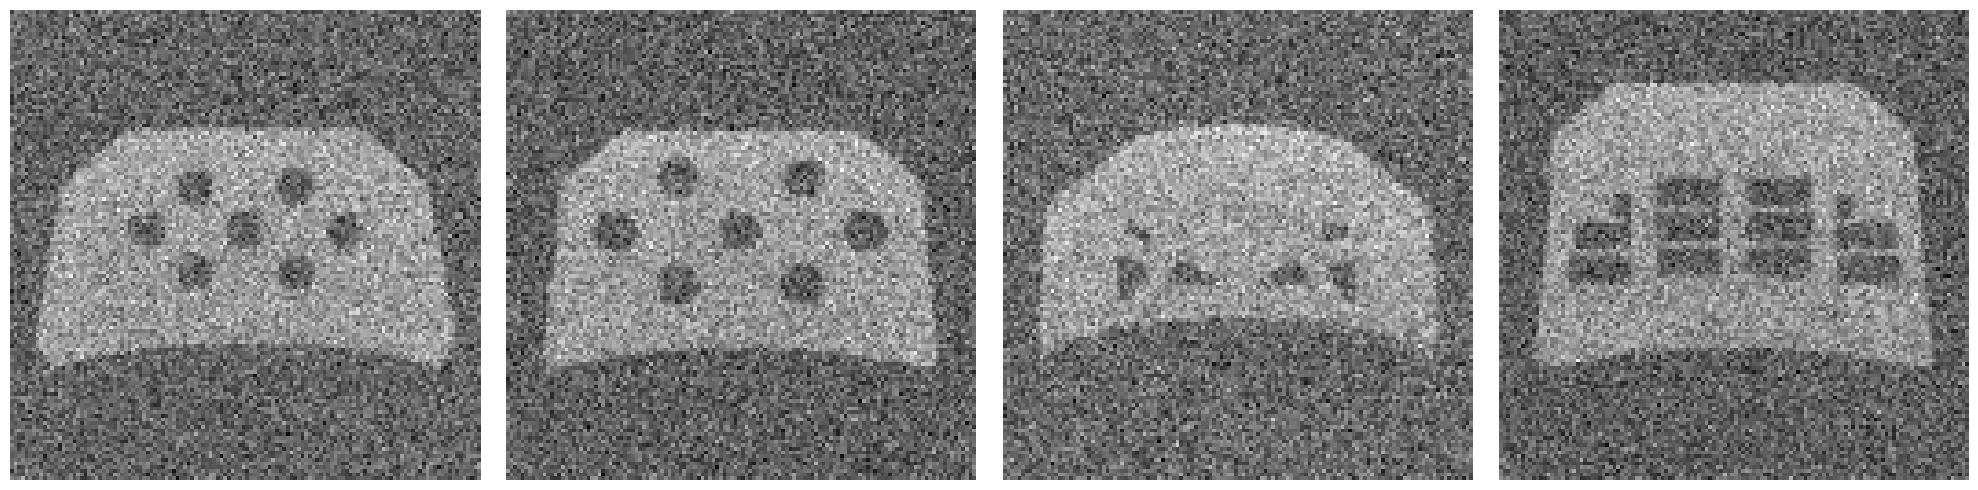

tensor(0)


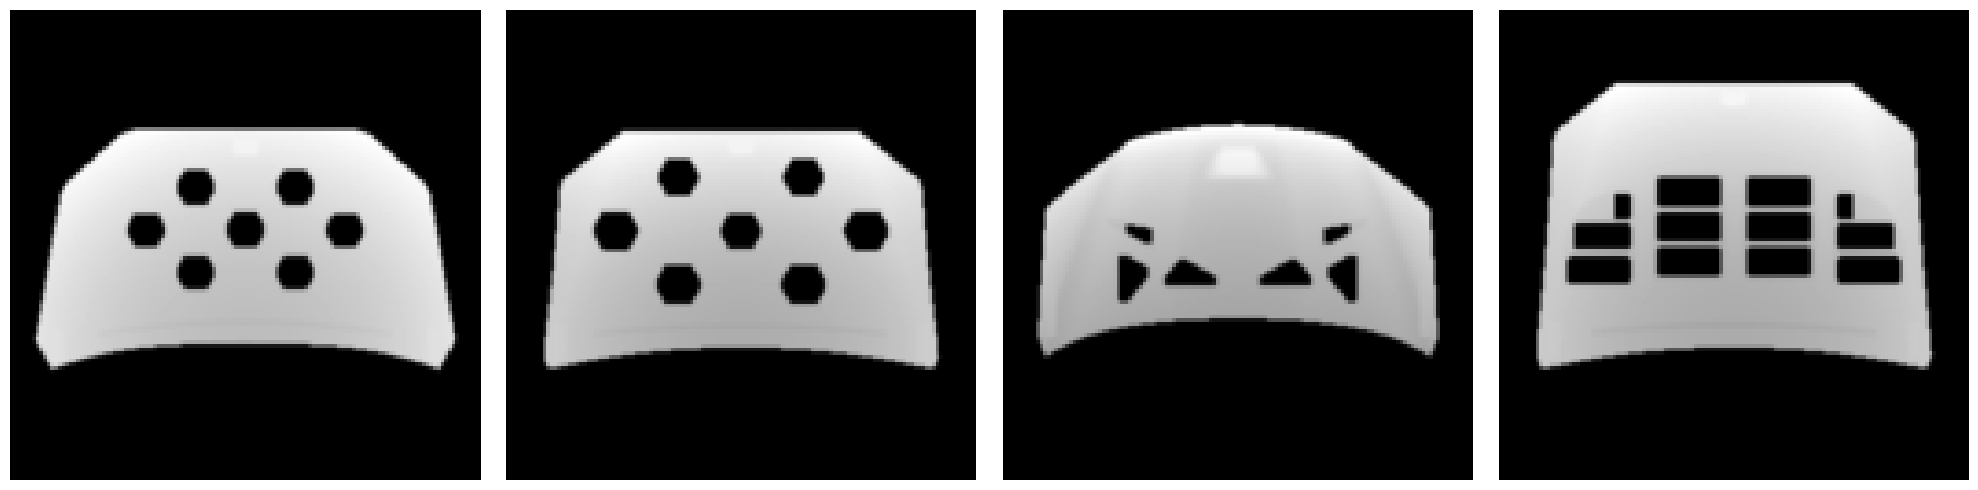

In [ ]:
for timestep in noise_scheduler.timesteps:
    print(timestep)

    noises = torch.randn(images.shape)
    noisy_images = noise_scheduler.add_noise(images, noises, timestep)
    show_img(noisy_images)

### **| Image Denoising Process**

UNet과 DDIM Noise Scheduler를 사용하여 노이즈가 있는 이미지를 점진적으로 복원하는 과정 구현합니다. 가이드 코드는 [Hugging Face DDIM 파이프라인](https://github.com/huggingface/diffusers/blob/main/src/diffusers/pipelines/ddim/pipeline_ddim.py)에서 확인할 수 있습니다.

tensor(750)
tensor(500)
tensor(250)
tensor(0)
(4, 1, 128, 128)


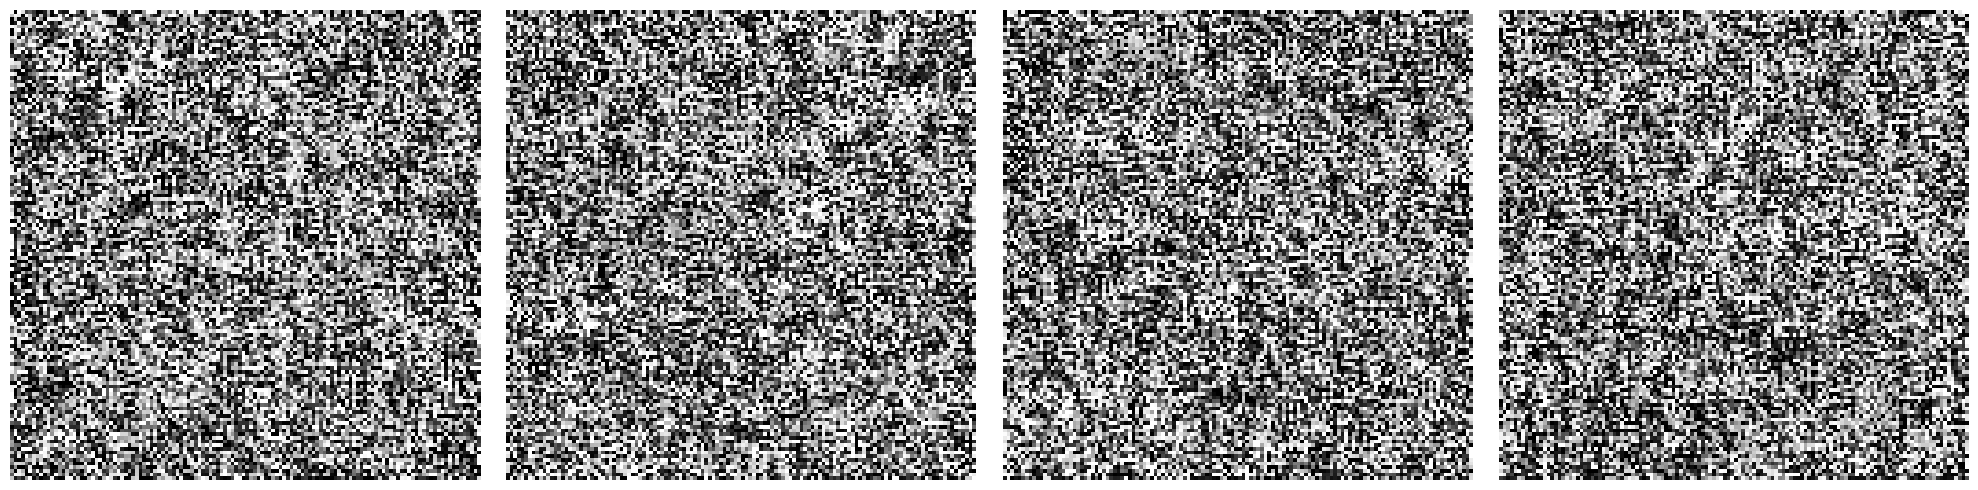

In [ ]:
noise_scheduler.set_timesteps(4) # inference steps 수 설정, 보통은 (20, 30, 50)
images =  torch.randn((4, 1, 128, 128)) # 초기 noise 설정
for timestep in noise_scheduler.timesteps: # timesteps 만큼 반복하기
    print(timestep)
    with torch.no_grad(): # 가중치 계산 비활성화
        pred_noises = unet(images, timestep).sample # unet 작동
        images  = noise_scheduler.step(pred_noises, timestep, images).prev_sample # noise 제거 step

images = images.numpy()
print(images.shape)
show_img(images[:,0])

## **(3) Model**

### **| Defining the Diffusion Model**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random, os

from diffusers import DDIMScheduler
from accelerate import Accelerator
from diffusers.optimization import get_cosine_schedule_with_warmup
from tqdm.auto import tqdm



class DiffusionModel():
    def __init__(self,
                 sample_size = 128,
                 in_channels = 1,
                 out_channels = 1,
                 layers_per_block = 1,
                 block_out_channels = [64, 128, 256, 512],
                 num_train_timesteps=1000,
                 dtype = torch.float16,
                 device = 'cuda'
                ):

        # init
        self.sample_size = sample_size
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.layers_per_block = layers_per_block
        self.block_out_channels = block_out_channels
        self.num_train_timesteps = num_train_timesteps

        self.dtype = dtype
        self.device = device
        if self.dtype == torch.float16:
            self.mp = 'fp16'
        else:
            self.mp = 'no'

        # base modules
        self.unet = UNet2DModel(
            sample_size = sample_size,
            in_channels = in_channels,
            out_channels = out_channels,
            layers_per_block = layers_per_block,
            block_out_channels = block_out_channels,
        )

        self.noise_scheduler = DDIMScheduler(num_train_timesteps=num_train_timesteps)

        # Initialize model
        accelerator = Accelerator(mixed_precision=self.mp)
        self.unet = accelerator.prepare(self.unet)


    def load_unet_weight(self, path):
        self.unet.load_state_dict(torch.load(path, map_location='cuda'))

    def infer(self,
              n=4,
              seed=0,
              num_inference_steps=30,
              ):

        generator=torch.manual_seed(seed)

        self.noise_scheduler.set_timesteps(num_inference_steps)
        shape = (n, self.in_channels, self.sample_size, self.sample_size)
        images = torch.randn(shape, generator=generator).to(self.device) # 초기 noise 설정

        for timestep in self.noise_scheduler.timesteps: # timesteps 만큼 반복하기
            with torch.no_grad(): # 가중치 계산 비활성화
                pred_noises = self.unet(images.to(self.device), timestep.to(self.device)).sample # unet 작동
                images  = self.noise_scheduler.step(pred_noises, timestep, images, generator=generator).prev_sample # noise scheduler 작동

        return images


    def train( self,
               dataset,
               output_dir,
               num_epochs = 10,
               gradient_accumulation_steps = 1,
               learning_rate = 1e-4,
               lr_warmup_steps = 100,
               seed = 0,
             ):

        # fix random seed
        torch.manual_seed(seed)
        random.seed(seed)

        # Initialize accelerator
        accelerator = Accelerator(
            mixed_precision=self.mp,
            gradient_accumulation_steps=gradient_accumulation_steps,
            project_dir=os.path.join(output_dir, "logs"),
        )

        # opt, lr scheduler
        optimizer = torch.optim.AdamW(self.unet.parameters(), lr=learning_rate)
        lr_scheduler = get_cosine_schedule_with_warmup(
            optimizer=optimizer,
            num_warmup_steps=lr_warmup_steps,
            num_training_steps=(len(dataset) * num_epochs),
        )

        self.noise_scheduler.set_timesteps(self.num_train_timesteps)

        # to accelerator
        self.unet, optimizer, dataset, lr_scheduler = accelerator.prepare(
            self.unet, optimizer, dataset, lr_scheduler
        )

        # make output_dir
        if output_dir is not None:
            os.makedirs(output_dir, exist_ok=True)

        # Train loop
        global_step = 0
        for epoch in range(num_epochs):
            progress_bar = tqdm(total=len(dataset))
            progress_bar.set_description(f"Epoch {epoch}")

            for step, imgs in enumerate(dataset):

                noise = torch.randn(imgs.shape).to(self.device)
                timesteps = torch.randint(
                    0, self.noise_scheduler.config.num_train_timesteps,
                    (imgs.shape[0],),
                    device=self.device
                ).long()
                noisy_images = self.noise_scheduler.add_noise(imgs, noise, timesteps)

                with accelerator.accumulate(self.unet):

                    noise_pred = self.unet(
                        noisy_images,
                        timesteps,
                    ).sample

                    loss = F.mse_loss(noise_pred, noise)
                    accelerator.backward(loss)
                    accelerator.clip_grad_norm_(self.unet.parameters(), 1.0)

                    optimizer.step()
                    lr_scheduler.step()
                    optimizer.zero_grad()

                # End batch
                progress_bar.update(1)
                logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
                progress_bar.set_postfix(**logs)
                accelerator.log(logs, step=global_step)
                global_step += 1


            # End epoch
            images = self.infer(seed=seed)
            show_img(
                images,
                save_path=f"{output_dir}/sample_{epoch:05d}.png",
                cmap=None,
                colorbar=True,
                axis='on',
            )

            torch.save(
                self.unet.state_dict(),
                f'{output_dir}/unet_weights.pth'
            )

### **| Training**

* 모델 객체 생성

In [ ]:
model = DiffusionModel()

* 모델 학습

In [ ]:
loader = pp.get_loader()
model.train(loader, './test', num_epochs=30)

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

### **| Generation**

* 저장된 weight 불러오기

In [ ]:
model.load_unet_weight('./test/unet_weights.pth')

* 이미지 생성

torch.Size([4, 1, 128, 128])


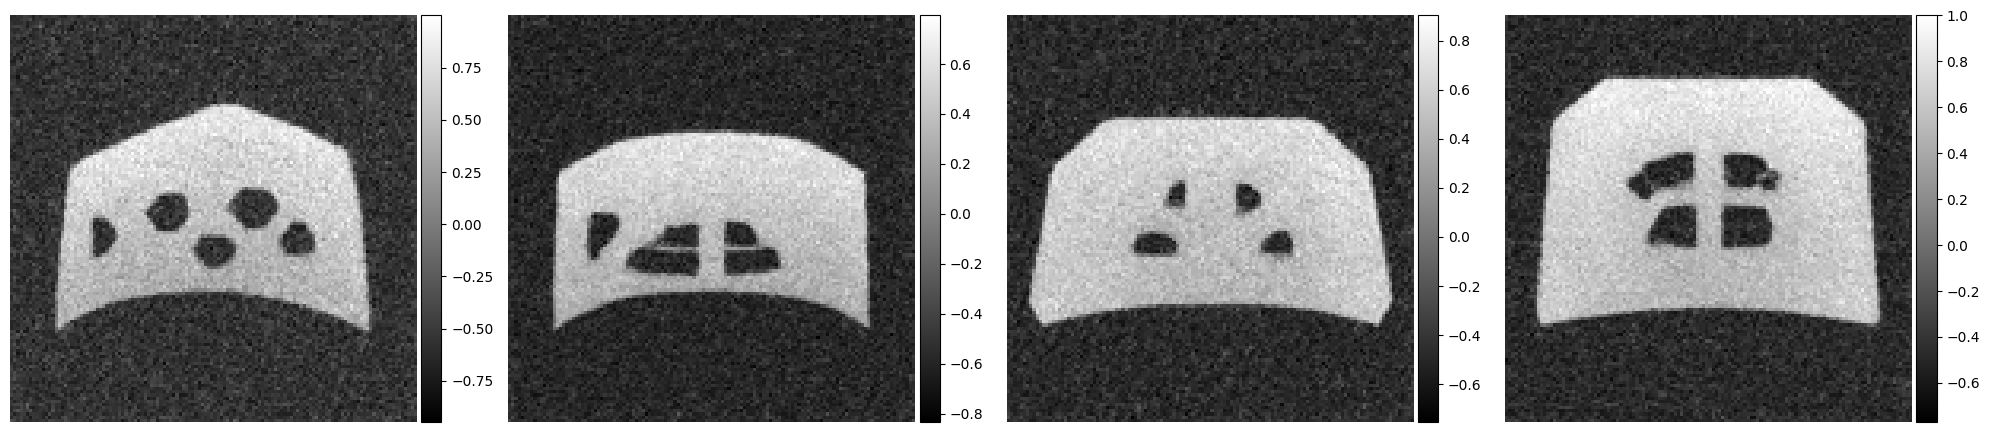

torch.Size([4, 1, 128, 128])


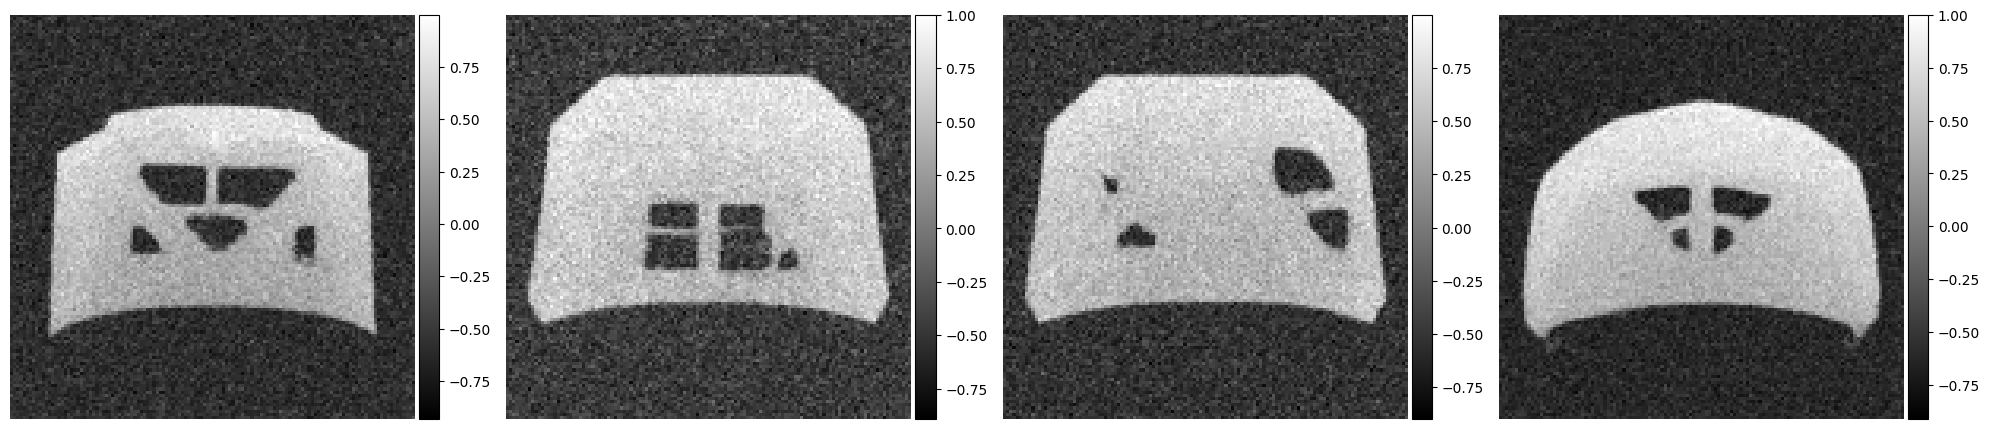

torch.Size([4, 1, 128, 128])


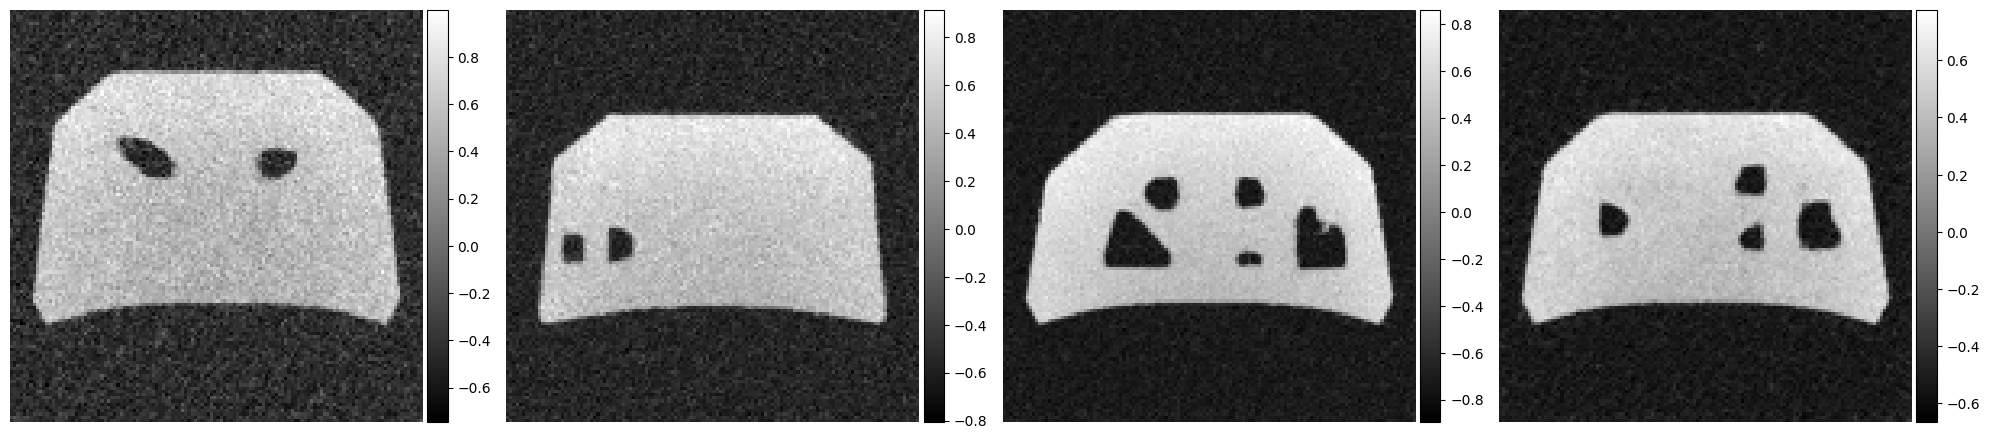

In [ ]:
for seed in range(3):
  outputs = model.infer(seed=seed)
  print(outputs.shape)
  show_img(outputs, colorbar=True)